🚀 EMPLOYEE PREDICTION MODEL - COMPLETE PIPELINE
📋 CONFIGURATION:
   Prophet changepoint_prior_scale: 0.05
   Prophet seasonality_prior_scale: 8.0
   Prophet monthly fourier order: 5
   Prophet quarterly fourier order: 3

📂 BLOCK 1: DATA LOADING & PREPROCESSING
📥 INPUT: final_df_binary.csv
📊 DATA OVERVIEW:
   Total records: 10,956
   Date range: 2021-01-01 00:00:00 to 2025-12-31 00:00:00
   Sections: 6
   Training data: 6,570 records (2021-2023)
   Test data: 2,196 records (2024)

📤 OUTPUT DataFrames:
   - train_data: Training dataset (2021-2023)
   - test_data: Test dataset (2024)
   - df: Complete preprocessed dataset

🔍 SAMPLE DATA:
        date section_id  employees_on_duty  total_task_time_minutes  \
0 2021-01-01    SEC-001                  1               834.569483   
1 2021-01-01    SEC-002                  4              1525.368990   
2 2021-01-01    SEC-003                  2               662.095279   
3 2021-01-01    SEC-004                  4              1499.112620   
4 

21:36:57 - cmdstanpy - INFO - Chain [1] start processing
21:36:58 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 241 working days (Train MAE: 430.4)
   Forecasting SEC-002...


21:36:59 - cmdstanpy - INFO - Chain [1] start processing
21:36:59 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 241 working days (Train MAE: 492.0)
   Forecasting SEC-003...


21:37:00 - cmdstanpy - INFO - Chain [1] start processing
21:37:00 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 241 working days (Train MAE: 399.9)
   Forecasting SEC-004...


21:37:01 - cmdstanpy - INFO - Chain [1] start processing
21:37:02 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 241 working days (Train MAE: 440.0)
   Forecasting SEC-005...


21:37:03 - cmdstanpy - INFO - Chain [1] start processing
21:37:03 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 241 working days (Train MAE: 1119.8)
   Forecasting SEC-006...


21:37:04 - cmdstanpy - INFO - Chain [1] start processing
21:37:04 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 241 working days (Train MAE: 833.3)

📤 OUTPUT:
   - task_forecasts: Dictionary with 6 section forecasts
   - task_time_models: Dictionary with 6 trained Prophet models
   - prophet_results_df: Prophet forecasting performance by section

🔍 PROPHET FORECAST SUMMARY:
  section_id  training_samples  forecast_days  train_mae  \
0    SEC-001               727            241     430.36   
1    SEC-002               727            241     492.01   
2    SEC-003               727            241     399.91   
3    SEC-004               727            241     440.04   
4    SEC-005               727            241    1119.78   
5    SEC-006               727            241     833.31   

   avg_predicted_task_time  
0                   819.76  
1                  1371.22  
2                   915.38  
3                  1046.09  
4                  2479.19  
5                  2226.71  

🔄 BLOCK 5: TASK TIME → EMPLOYEE CONVERSION
📥 INPUT: task_forecasts (Prophet predictions), e

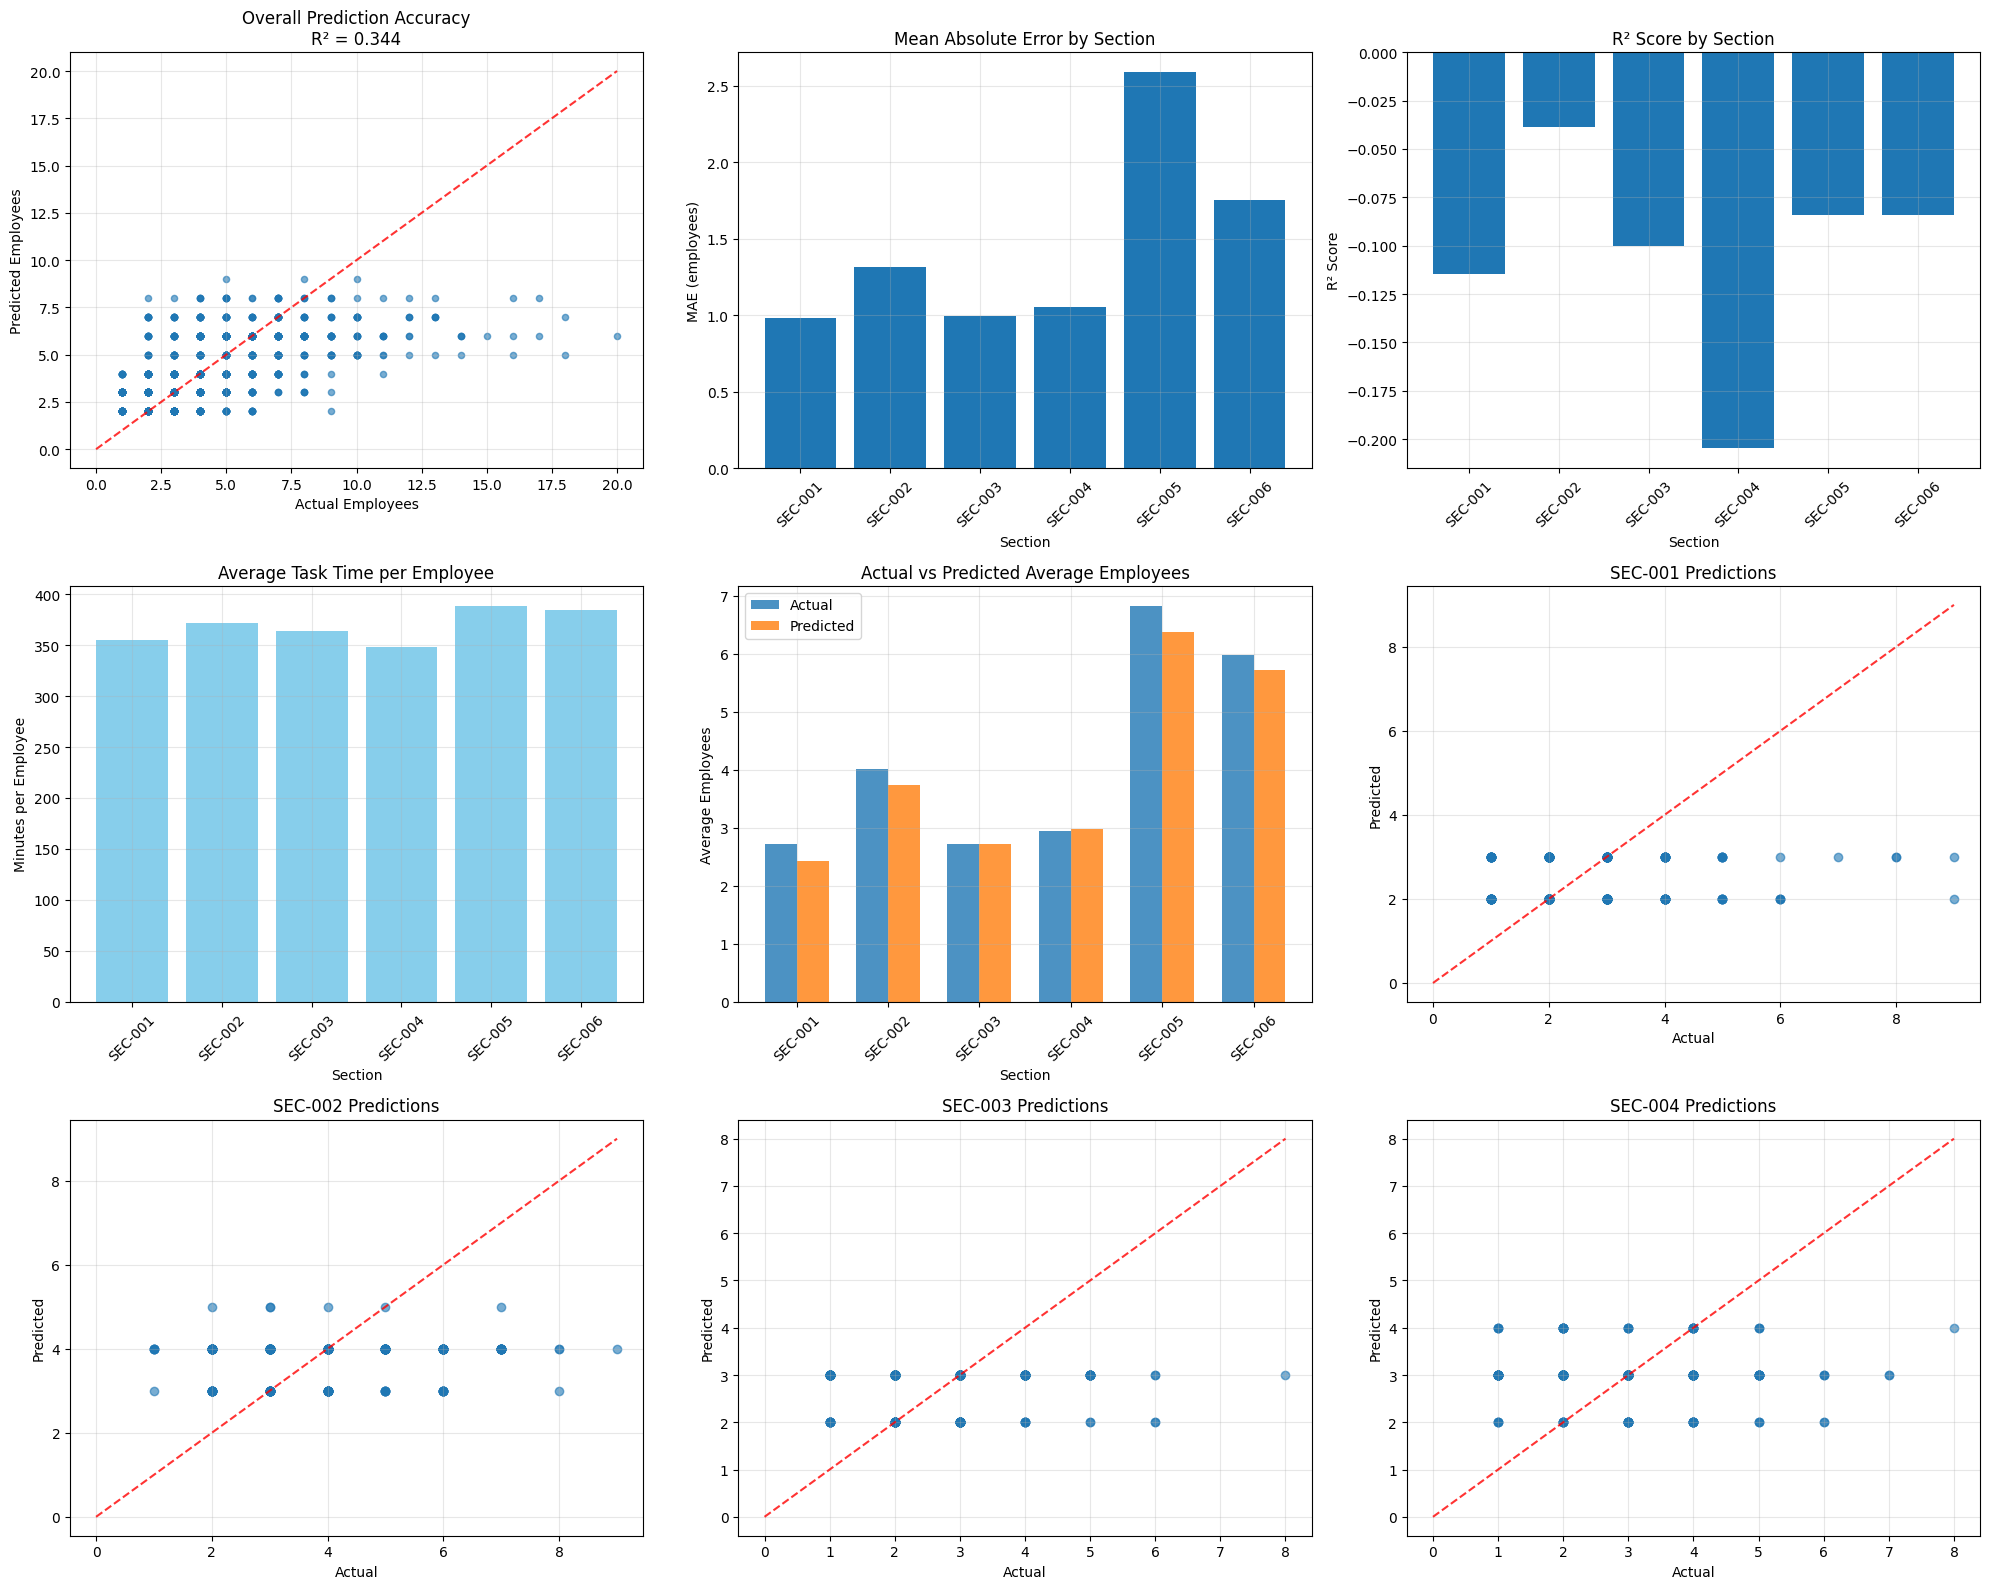

📊 CREATING MONTHLY TRENDS VISUALIZATION...


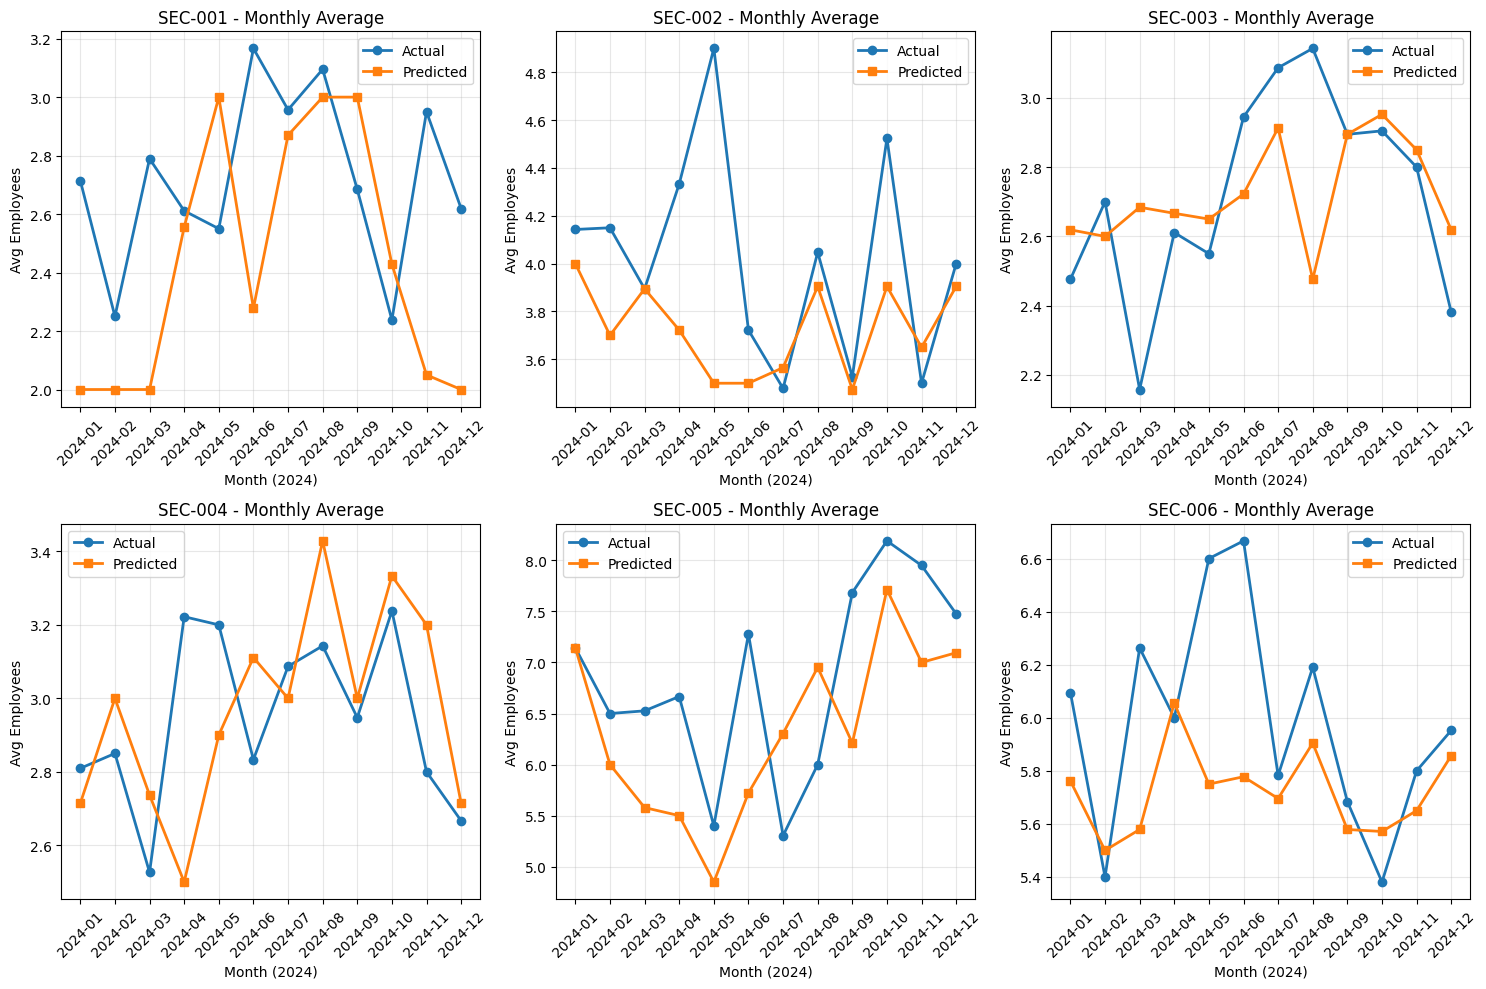


📤 OUTPUT:
   - model_validation_results.png: Main validation visualizations
   - monthly_trends_comparison.png: Monthly trend analysis
   - monthly_comparison: DataFrame with monthly aggregated data

💾 BLOCK 9: SAVE RESULTS
📥 INPUT: All analysis and prediction DataFrames
✅ VALIDATION COMPLETE!

📁 FILES SAVED:
   - 2024_validation_predictions.csv: Complete predictions vs actuals
   - validation_performance_by_section.csv: Section-wise evaluation metrics
   - training_correlations.csv: Employee-task time correlations
   - training_statistics.csv: Training data statistics
   - regression_model_results.csv: Regression model performance
   - prophet_forecast_results.csv: Prophet forecasting results
   - task_to_employee_conversion.csv: Task time to employee conversion metrics
   - monthly_comparison_2024.csv: Monthly trends comparison

📊 FINAL VALIDATION SUMMARY:
   Section    MAE   RMSE     R²  Avg_Task_Per_Employee  Working_Days  \
0  SEC-001  0.979  1.466 -0.114                354.539  

In [1]:
# ===============================
# 📊 EMPLOYEE PREDICTION MODEL
# Complete Pipeline: Task Time Forecasting → Employee Count Prediction
# ===============================

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("🚀 EMPLOYEE PREDICTION MODEL - COMPLETE PIPELINE")
print("=" * 60)

# ===============================
# 🔧 CONFIGURATION PARAMETERS
# ===============================
# Prophet hyperparameters (tune these later)
PROPHET_PARAMS = {
    'changepoint_prior_scale': 0.05,
    'seasonality_prior_scale': 8.0,
    'fourier_order_monthly': 5,
    'fourier_order_quarterly': 3
}

# Model parameters
HUBER_EPSILON = 1.35
REGRESSION_WEIGHT_THRESHOLD = 0.9  # R² threshold for regression weight
REGRESSION_WEIGHT_HIGH = 0.8       # Weight when R² > threshold
REGRESSION_WEIGHT_LOW = 0.6        # Weight when R² <= threshold

print("📋 CONFIGURATION:")
print(f"   Prophet changepoint_prior_scale: {PROPHET_PARAMS['changepoint_prior_scale']}")
print(f"   Prophet seasonality_prior_scale: {PROPHET_PARAMS['seasonality_prior_scale']}")
print(f"   Prophet monthly fourier order: {PROPHET_PARAMS['fourier_order_monthly']}")
print(f"   Prophet quarterly fourier order: {PROPHET_PARAMS['fourier_order_quarterly']}")

# ===============================
# 📂 BLOCK 1: DATA LOADING & PREPROCESSING
# ===============================
print("\n" + "=" * 60)
print("📂 BLOCK 1: DATA LOADING & PREPROCESSING")
print("=" * 60)

# Input: Raw CSV file
print("📥 INPUT: final_df_binary.csv")

# Load and preprocess data
df = pd.read_csv('final_df_binary.csv')
df['date'] = pd.to_datetime(df['date'])

# Feature engineering
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['is_working_day'] = ((df['is_holiday'] == 0) & (df['is_weekend'] == 0)).astype(int)

# Train-Test Split
train_data = df[df['year'] <= 2023].copy()
test_data = df[df['year'] == 2024].copy()

print("📊 DATA OVERVIEW:")
print(f"   Total records: {len(df):,}")
print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   Sections: {df['section_id'].nunique()}")
print(f"   Training data: {len(train_data):,} records (2021-2023)")
print(f"   Test data: {len(test_data):,} records (2024)")

# Output: Preprocessed DataFrames
print("\n📤 OUTPUT DataFrames:")
print("   - train_data: Training dataset (2021-2023)")
print("   - test_data: Test dataset (2024)")
print("   - df: Complete preprocessed dataset")

print(f"\n🔍 SAMPLE DATA:")
print(train_data.head())

# ===============================
# 📈 BLOCK 2: TRAINING DATA ANALYSIS
# ===============================
print("\n" + "=" * 60)
print("📈 BLOCK 2: TRAINING DATA ANALYSIS")
print("=" * 60)

# Input: train_data DataFrame
print("📥 INPUT: train_data (2021-2023 data)")

working_train = train_data[train_data['is_working_day'] == 1]

print("📊 CORRELATION ANALYSIS (Employee vs Task Time):")
correlations = {}
correlation_results = []

for section in working_train['section_id'].unique():
    section_data = working_train[working_train['section_id'] == section]
    if len(section_data) > 20:
        corr = section_data['employees_on_duty'].corr(section_data['total_task_time_minutes'])
        correlations[section] = corr
        correlation_results.append({
            'section_id': section,
            'correlation': corr,
            'data_points': len(section_data)
        })
        print(f"   {section}: {corr:.3f} ({len(section_data)} data points)")

# Create correlation DataFrame
correlation_df = pd.DataFrame(correlation_results)

print(f"\n📈 TRAINING STATISTICS BY SECTION:")
stats = working_train.groupby('section_id').agg({
    'employees_on_duty': ['count', 'mean', 'std', 'min', 'max'],
    'total_task_time_minutes': ['mean', 'std']
}).round(2)

training_stats = []
for section in stats.index:
    emp_stats = stats.loc[section, 'employees_on_duty']
    task_stats = stats.loc[section, 'total_task_time_minutes']
    
    training_stats.append({
        'section_id': section,
        'working_days': emp_stats['count'],
        'emp_mean': emp_stats['mean'],
        'emp_std': emp_stats['std'],
        'emp_min': emp_stats['min'],
        'emp_max': emp_stats['max'],
        'task_mean': task_stats['mean'],
        'task_std': task_stats['std']
    })
    
    print(f"   {section}:")
    print(f"      Working days: {emp_stats['count']:.0f}")
    print(f"      Employees: {emp_stats['mean']:.1f} ± {emp_stats['std']:.1f} (range: {emp_stats['min']:.0f}-{emp_stats['max']:.0f})")
    print(f"      Task time: {task_stats['mean']:.0f} ± {task_stats['std']:.0f} minutes")

# Create training statistics DataFrame
training_stats_df = pd.DataFrame(training_stats)

# Output: Analysis DataFrames
print("\n📤 OUTPUT DataFrames:")
print("   - correlation_df: Correlation between employees and task time by section")
print("   - training_stats_df: Comprehensive training statistics by section")
print("   - working_train: Filtered training data (working days only)")

# ===============================
# 🤖 BLOCK 3: EMPLOYEE REGRESSION MODELS
# ===============================
print("\n" + "=" * 60)
print("🤖 BLOCK 3: EMPLOYEE REGRESSION MODELS")
print("=" * 60)

# Input: working_train DataFrame
print("📥 INPUT: working_train (working days training data)")

employee_models = {}
regression_results = []

print("🔨 BUILDING REGRESSION MODELS (Task Time → Employee Count):")

for section in working_train['section_id'].unique():
    section_data = working_train[working_train['section_id'] == section]

    if len(section_data) > 30:
        # Prepare regression data
        X = section_data[['total_task_time_minutes']].values
        y = section_data['employees_on_duty'].values

        # Build Huber Regression model
        model = HuberRegressor(epsilon=HUBER_EPSILON)
        model.fit(X, y)

        # Calculate efficiency metrics
        valid_data = section_data[section_data['employees_on_duty'] > 0].copy()
        valid_data['task_per_emp'] = valid_data['total_task_time_minutes'] / valid_data['employees_on_duty']

        # Store model information
        r2_score_val = model.score(X, y)
        
        employee_models[section] = {
            'regression_model': model,
            'avg_task_per_employee': valid_data['task_per_emp'].median(),
            'min_employees': section_data['employees_on_duty'].min(),
            'max_employees': section_data['employees_on_duty'].max(),
            'training_r2': r2_score_val
        }

        regression_results.append({
            'section_id': section,
            'r2_score': r2_score_val,
            'avg_efficiency': valid_data['task_per_emp'].median(),
            'min_employees': section_data['employees_on_duty'].min(),
            'max_employees': section_data['employees_on_duty'].max(),
            'training_samples': len(section_data)
        })

        print(f"   {section}: R² = {r2_score_val:.3f}, Avg efficiency = {valid_data['task_per_emp'].median():.1f} min/emp")

# Create regression results DataFrame
regression_results_df = pd.DataFrame(regression_results)

# Output: Models and results
print(f"\n📤 OUTPUT:")
print(f"   - employee_models: Dictionary with {len(employee_models)} trained regression models")
print("   - regression_results_df: Regression performance metrics by section")

print(f"\n🔍 REGRESSION SUMMARY:")
print(regression_results_df.round(2))

# ===============================
# 🔮 BLOCK 4: PROPHET TASK TIME FORECASTING
# ===============================
print("\n" + "=" * 60)
print("🔮 BLOCK 4: PROPHET TASK TIME FORECASTING")
print("=" * 60)

# Input: working_train DataFrame
print("📥 INPUT: working_train (working days training data)")

task_forecasts = {}
task_time_models = {}
prophet_results = []

print("📊 FORECASTING 2024 TASK TIME WITH PROPHET:")

for section in working_train['section_id'].unique():
    print(f"   Forecasting {section}...")
    section_data = working_train[working_train['section_id'] == section].copy()

    if len(section_data) < 50:
        print(f"      ⚠️  Insufficient training data ({len(section_data)} records)")
        continue

    # Prepare Prophet DataFrame
    prophet_df = section_data[['date', 'total_task_time_minutes']].copy()
    prophet_df.columns = ['ds', 'y']
    prophet_df = prophet_df.sort_values('ds')

    # Build Prophet model with configured parameters
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=PROPHET_PARAMS['changepoint_prior_scale'],
        seasonality_prior_scale=PROPHET_PARAMS['seasonality_prior_scale']
    )

    # Add custom seasonalities
    model.add_seasonality(name='monthly', period=30.5, fourier_order=PROPHET_PARAMS['fourier_order_monthly'])
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=PROPHET_PARAMS['fourier_order_quarterly'])
    
    # Fit model
    model.fit(prophet_df)

    # Get test dates for this section
    test_working = test_data[(test_data['section_id'] == section) & (test_data['is_working_day'] == 1)]['date'].values

    if len(test_working) > 0:
        # Make predictions
        future_df = pd.DataFrame({'ds': test_working})
        forecast = model.predict(future_df)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)  # No negative predictions

        # Store forecasts
        task_forecasts[section] = {
            'dates': test_working,
            'predictions': forecast['yhat'].values
        }

        task_time_models[section] = model
        
        # Calculate training accuracy
        train_future = prophet_df[['ds']]
        train_forecast = model.predict(train_future)
        train_mae = mean_absolute_error(prophet_df['y'], train_forecast['yhat'])
        
        prophet_results.append({
            'section_id': section,
            'training_samples': len(prophet_df),
            'forecast_days': len(test_working),
            'train_mae': train_mae,
            'avg_predicted_task_time': forecast['yhat'].mean()
        })
        
        print(f"      → Forecasted {len(test_working)} working days (Train MAE: {train_mae:.1f})")

# Create Prophet results DataFrame
prophet_results_df = pd.DataFrame(prophet_results)

# Output: Forecasts and models
print(f"\n📤 OUTPUT:")
print(f"   - task_forecasts: Dictionary with {len(task_forecasts)} section forecasts")
print(f"   - task_time_models: Dictionary with {len(task_time_models)} trained Prophet models")
print("   - prophet_results_df: Prophet forecasting performance by section")

print(f"\n🔍 PROPHET FORECAST SUMMARY:")
print(prophet_results_df.round(2))

# ===============================
# 🔄 BLOCK 5: TASK TIME → EMPLOYEE CONVERSION
# ===============================
print("\n" + "=" * 60)
print("🔄 BLOCK 5: TASK TIME → EMPLOYEE CONVERSION")
print("=" * 60)

# Input: task_forecasts, employee_models
print("📥 INPUT: task_forecasts (Prophet predictions), employee_models (Regression models)")

employee_predictions = {}
conversion_results = []

print("🔄 CONVERTING TASK TIME FORECASTS TO EMPLOYEE PREDICTIONS:")

for section, forecast_data in task_forecasts.items():
    if section not in employee_models:
        print(f"   ⚠️  {section}: No regression model available")
        continue

    model_info = employee_models[section]
    dates = forecast_data['dates']
    predicted_task_time = forecast_data['predictions']

    # Method 1: Regression prediction
    predicted_employees_reg = model_info['regression_model'].predict(predicted_task_time.reshape(-1, 1))
    
    # Method 2: Efficiency-based prediction
    predicted_employees_eff = predicted_task_time / model_info['avg_task_per_employee']

    # Combine predictions based on regression R²
    r2_val = model_info['training_r2']
    weight_reg = REGRESSION_WEIGHT_HIGH if r2_val > REGRESSION_WEIGHT_THRESHOLD else REGRESSION_WEIGHT_LOW

    final_predictions = weight_reg * predicted_employees_reg + (1 - weight_reg) * predicted_employees_eff
    final_predictions = np.round(final_predictions).astype(int)
    
    # Apply constraints
    final_predictions = np.clip(
        final_predictions,
        max(1, model_info['min_employees']),
        int(model_info['max_employees'] * 1.2)  # Allow 20% above historical max
    )

    employee_predictions[section] = {
        'dates': dates,
        'predictions': final_predictions
    }
    
    conversion_results.append({
        'section_id': section,
        'forecast_days': len(dates),
        'avg_predicted_employees': final_predictions.mean(),
        'min_predicted': final_predictions.min(),
        'max_predicted': final_predictions.max(),
        'regression_weight': weight_reg,
        'model_r2': r2_val
    })

    print(f"   {section}: {len(dates)} days, Avg employees: {final_predictions.mean():.1f} (Weight: {weight_reg:.1f}, R²: {r2_val:.3f})")

# Create conversion results DataFrame
conversion_results_df = pd.DataFrame(conversion_results)

# Output: Employee predictions
print(f"\n📤 OUTPUT:")
print(f"   - employee_predictions: Dictionary with {len(employee_predictions)} section predictions")
print("   - conversion_results_df: Conversion statistics by section")

print(f"\n🔍 CONVERSION SUMMARY:")
print(conversion_results_df.round(3))

# ===============================
# 📊 BLOCK 6: PREDICTIONS ASSEMBLY
# ===============================
print("\n" + "=" * 60)
print("📊 BLOCK 6: PREDICTIONS ASSEMBLY")
print("=" * 60)

# Input: test_data, employee_predictions
print("📥 INPUT: test_data (2024 data), employee_predictions (converted predictions)")

# Create complete predictions DataFrame
predictions_df = test_data.copy()
predictions_df['predicted_employee_count'] = 0

# Map predictions to DataFrame
for section, pred_data in employee_predictions.items():
    for date, pred in zip(pred_data['dates'], pred_data['predictions']):
        mask = (predictions_df['section_id'] == section) & (predictions_df['date'] == date)
        predictions_df.loc[mask, 'predicted_employee_count'] = pred

# Select relevant columns
predictions_df = predictions_df[['date', 'section_id', 'employees_on_duty', 
                                'total_task_time_minutes', 'predicted_employee_count', 'is_working_day']]

print("📊 PREDICTIONS ASSEMBLY COMPLETE:")
print(f"   Total predictions: {len(predictions_df):,} records")
print(f"   Working day predictions: {len(predictions_df[predictions_df['is_working_day'] == 1]):,} records")
print(f"   Sections with predictions: {predictions_df[predictions_df['predicted_employee_count'] > 0]['section_id'].nunique()}")

# Output: Complete predictions
print(f"\n📤 OUTPUT:")
print("   - predictions_df: Complete 2024 predictions with actual values")

print(f"\n🔍 PREDICTIONS SAMPLE:")
print(predictions_df[predictions_df['is_working_day'] == 1].head(10))

# ===============================
# 🎯 BLOCK 7: MODEL EVALUATION
# ===============================
print("\n" + "=" * 60)
print("🎯 BLOCK 7: MODEL EVALUATION")
print("=" * 60)

# Input: predictions_df
print("📥 INPUT: predictions_df (complete predictions with actuals)")

working_predictions = predictions_df[predictions_df['is_working_day'] == 1].copy()

# Overall performance metrics
mae_overall = mean_absolute_error(working_predictions['employees_on_duty'], working_predictions['predicted_employee_count'])
rmse_overall = np.sqrt(mean_squared_error(working_predictions['employees_on_duty'], working_predictions['predicted_employee_count']))
r2_overall = r2_score(working_predictions['employees_on_duty'], working_predictions['predicted_employee_count'])

print(f"🎯 OVERALL PERFORMANCE:")
print(f"   MAE: {mae_overall:.2f} employees")
print(f"   RMSE: {rmse_overall:.2f} employees")
print(f"   R²: {r2_overall:.3f}")
print(f"   Records evaluated: {len(working_predictions):,}")

# Section-wise evaluation
print(f"\n📊 SECTION-WISE PERFORMANCE:")
section_evaluation = []

for section in working_predictions['section_id'].unique():
    section_data = working_predictions[working_predictions['section_id'] == section]
    if len(section_data) > 0:
        mae_section = mean_absolute_error(section_data['employees_on_duty'], section_data['predicted_employee_count'])
        rmse_section = np.sqrt(mean_squared_error(section_data['employees_on_duty'], section_data['predicted_employee_count']))
        r2_section = r2_score(section_data['employees_on_duty'], section_data['predicted_employee_count'])

        # Calculate efficiency
        valid_section = section_data[section_data['employees_on_duty'] > 0].copy()
        avg_task_per_emp = (valid_section['total_task_time_minutes'] / valid_section['employees_on_duty']).mean()

        section_evaluation.append({
            'Section': section,
            'MAE': mae_section,
            'RMSE': rmse_section,
            'R²': r2_section,
            'Avg_Task_Per_Employee': avg_task_per_emp,
            'Working_Days': len(section_data),
            'Actual_Avg': section_data['employees_on_duty'].mean(),
            'Predicted_Avg': section_data['predicted_employee_count'].mean()
        })

        print(f"   {section}:")
        print(f"      MAE: {mae_section:.2f}, RMSE: {rmse_section:.2f}, R²: {r2_section:.3f}")
        print(f"      Avg task/employee: {avg_task_per_emp:.1f} minutes")
        print(f"      Actual avg: {section_data['employees_on_duty'].mean():.1f}, Predicted avg: {section_data['predicted_employee_count'].mean():.1f}")

# Create evaluation results DataFrame
section_evaluation_df = pd.DataFrame(section_evaluation)

# Output: Evaluation metrics
print(f"\n📤 OUTPUT:")
print("   - working_predictions: Working day predictions with actuals")
print("   - section_evaluation_df: Detailed evaluation metrics by section")

print(f"\n🔍 EVALUATION SUMMARY:")
print(section_evaluation_df.round(3))

# ===============================
# 📈 BLOCK 8: VISUALIZATIONS
# ===============================
print("\n" + "=" * 60)
print("📈 BLOCK 8: VISUALIZATIONS")
print("=" * 60)

# Input: working_predictions, section_evaluation_df
print("📥 INPUT: working_predictions, section_evaluation_df")

print("📊 CREATING COMPREHENSIVE VISUALIZATIONS...")

# Create main visualization grid
fig = plt.figure(figsize=(20, 16))

# 1. Overall prediction accuracy
plt.subplot(3, 3, 1)
plt.scatter(working_predictions['employees_on_duty'], working_predictions['predicted_employee_count'], alpha=0.6, s=20)
plt.plot([0, working_predictions['employees_on_duty'].max()], [0, working_predictions['employees_on_duty'].max()], 'r--', alpha=0.8)
plt.xlabel('Actual Employees')
plt.ylabel('Predicted Employees')
plt.title(f'Overall Prediction Accuracy\nR² = {r2_overall:.3f}')
plt.grid(True, alpha=0.3)

# 2. MAE by section
plt.subplot(3, 3, 2)
plt.bar(section_evaluation_df['Section'], section_evaluation_df['MAE'])
plt.xlabel('Section')
plt.ylabel('MAE (employees)')
plt.title('Mean Absolute Error by Section')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. R² by section
plt.subplot(3, 3, 3)
plt.bar(section_evaluation_df['Section'], section_evaluation_df['R²'])
plt.xlabel('Section')
plt.ylabel('R² Score')
plt.title('R² Score by Section')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 4. Task time per employee
plt.subplot(3, 3, 4)
plt.bar(section_evaluation_df['Section'], section_evaluation_df['Avg_Task_Per_Employee'], color='skyblue')
plt.xlabel('Section')
plt.ylabel('Minutes per Employee')
plt.title('Average Task Time per Employee')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 5. Actual vs Predicted averages
plt.subplot(3, 3, 5)
x = np.arange(len(section_evaluation_df))
width = 0.35
plt.bar(x - width/2, section_evaluation_df['Actual_Avg'], width, label='Actual', alpha=0.8)
plt.bar(x + width/2, section_evaluation_df['Predicted_Avg'], width, label='Predicted', alpha=0.8)
plt.xlabel('Section')
plt.ylabel('Average Employees')
plt.title('Actual vs Predicted Average Employees')
plt.xticks(x, section_evaluation_df['Section'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 6-9. Section-wise scatter plots
sections = working_predictions['section_id'].unique()[:4]
for i, section in enumerate(sections, 6):
    plt.subplot(3, 3, i)
    section_data = working_predictions[working_predictions['section_id'] == section]
    plt.scatter(section_data['employees_on_duty'], section_data['predicted_employee_count'], alpha=0.6)
    plt.plot([0, section_data['employees_on_duty'].max()], [0, section_data['employees_on_duty'].max()], 'r--', alpha=0.8)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{section} Predictions')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_validation_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Monthly trends comparison
print("📊 CREATING MONTHLY TRENDS VISUALIZATION...")
plt.figure(figsize=(15, 10))
working_predictions['year_month'] = working_predictions['date'].dt.to_period('M')
monthly_comparison = working_predictions.groupby(['year_month', 'section_id']).agg({
    'employees_on_duty': 'mean',
    'predicted_employee_count': 'mean'
}).reset_index()

sections = monthly_comparison['section_id'].unique()
for i, section in enumerate(sections):
    plt.subplot(2, 3, i+1)
    section_monthly = monthly_comparison[monthly_comparison['section_id'] == section]
    plt.plot(section_monthly['year_month'].astype(str), section_monthly['employees_on_duty'], 'o-', label='Actual', linewidth=2)
    plt.plot(section_monthly['year_month'].astype(str), section_monthly['predicted_employee_count'], 's-', label='Predicted', linewidth=2)
    plt.title(f'{section} - Monthly Average')
    plt.xlabel('Month (2024)')
    plt.ylabel('Avg Employees')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('monthly_trends_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Output: Visualization files
print(f"\n📤 OUTPUT:")
print("   - model_validation_results.png: Main validation visualizations")
print("   - monthly_trends_comparison.png: Monthly trend analysis")
print("   - monthly_comparison: DataFrame with monthly aggregated data")

# ===============================
# 💾 BLOCK 9: SAVE RESULTS
# ===============================
print("\n" + "=" * 60)
print("💾 BLOCK 9: SAVE RESULTS")
print("=" * 60)

# Input: All generated DataFrames
print("📥 INPUT: All analysis and prediction DataFrames")

# Save all important DataFrames
predictions_df.to_csv('2024_validation_predictions.csv', index=False)
section_evaluation_df.to_csv('validation_performance_by_section.csv', index=False)
correlation_df.to_csv('training_correlations.csv', index=False)
training_stats_df.to_csv('training_statistics.csv', index=False)
regression_results_df.to_csv('regression_model_results.csv', index=False)
prophet_results_df.to_csv('prophet_forecast_results.csv', index=False)
conversion_results_df.to_csv('task_to_employee_conversion.csv', index=False)
monthly_comparison.to_csv('monthly_comparison_2024.csv', index=False)

print("✅ VALIDATION COMPLETE!")
print(f"\n📁 FILES SAVED:")
print(f"   - 2024_validation_predictions.csv: Complete predictions vs actuals")
print(f"   - validation_performance_by_section.csv: Section-wise evaluation metrics")
print(f"   - training_correlations.csv: Employee-task time correlations")
print(f"   - training_statistics.csv: Training data statistics")
print(f"   - regression_model_results.csv: Regression model performance")
print(f"   - prophet_forecast_results.csv: Prophet forecasting results")
print(f"   - task_to_employee_conversion.csv: Task time to employee conversion metrics")
print(f"   - monthly_comparison_2024.csv: Monthly trends comparison")

print("\n📊 FINAL VALIDATION SUMMARY:")
print(section_evaluation_df.round(3))

# Model performance assessment
if mae_overall < 1.0:
    print(f"\n✅ MODEL PERFORMANCE EXCELLENT! (MAE: {mae_overall:.3f} < 1.0)")
    print("   Ready for 2025 forecasting deployment.")
elif mae_overall < 1.5:
    print(f"\n✅ MODEL PERFORMANCE GOOD! (MAE: {mae_overall:.3f} < 1.5)")
    print("   Suitable for production use.")
else:
    print(f"\n⚠️  MODEL PERFORMANCE NEEDS IMPROVEMENT (MAE: {mae_overall:.3f})")
    print("   Consider hyperparameter tuning before 2025 forecasting.")

print("\n🎉 PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
print("=" * 60)